# Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob

import imageio as im
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

/home/zaki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Global Parameters 

In [5]:
# data parameters
train_path = 'training_set'
test_path = 'test_set'
train_tfreocds_filename = 'train.tfr'
test_tfreocds_filename = 'test.tfr'
image_shape = (28, 28, 3)
n_classes = 3

# dataset parameter
batch_size = 16
buffer_size = 100
count = 202
# model parameters
default_strides = 0
default_kernel_size = 3
default_pool_size = 2
default_activation ='relu'

# Compiling parameters
loss = 'categorical_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
# training parameters
epochs = 10
validation_split = 0.15


## Build TFRecords

In [ ]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert(data_path, out_path, size=(150,150)):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.    
    print("Converting: " + out_path)
    
    
    # Number of images. Used when printing the progress.
    num_images = len(image_paths)    
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:        
        # Iterate over all the image-paths and class-labels.
        for i, (path, label) in enumerate(zip(image_paths, labels)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)
            # Load the image-file using matplotlib's imread function.
            img = Image.open(path)
            img = img.resize(size)
            img = np.array(img)
            # Convert the image to raw bytes.
            img_bytes = img.tostring()
            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
                }
            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)
            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)
            # Serialize the data.
            serialized = example.SerializeToString()        
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

## Load Data

In [5]:
dataset = tf.data.TFRecordDataset(data_path_train)

In [ ]:
def preprocess(x,y):
    pass

In [5]:
dataset = dataset.map(preprocess) \
    .batch(batch_size) \
    .repeate(count) \
    .shuffle(buffer_size) \
    .prefetch() 

#### Preview

In [6]:
iter = dataset.make_initializable_iterator()
data_iter = iter.get_next()

with tf.Session() as sess:
    sess.run(iter.initializer)
    preview_data = sess.run(data_iter)


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
print(f'the batch images shape is :{preview_data[0].shape}')
print(f'the batch labels shape is :{preview_data[1].shape}')


### Assumptions

In [4]:
result_batch_shape_images = preview_data[0].shape
expected_batch_shape_images = (batch_size,) + image_shape
assert expected_batch_shape_images == result_batch_shape_images, f"the result batch shape is not expected to be {result_batch_shape_images}"

result_batch_shape_labels = preview_data[1].shape
expected_batch_shape_labels = (batch_size,)
assert expected_batch_shape_labels == result_batch_shape_labels, f"the result batch shape is not expected to be {result_batch_shape_labels}"


AssertionError: the result batch shape is not expected to be (10, 300, 300, 1)

### Model

In [5]:
model = keras.Sequential([
    
    #CONV 1
    Conv2D(32, kernel_size=default_kernel_size, padding='same', activation=default_activation, input_shape=image_shape, name='Conv-1-1-layer'),
    Conv2D(32, kernel_size=default_kernel_size, padding='same', name='Conv-1-2-layer'),
    MaxPooling2D(pool_size=default_pool_size, name='Pool-1-layer'),
    Dropout(0.5, name='Dropout-1-layer'),
    
    #CONV 2
    Conv2D(32, kernel_size=default_kernel_size, padding='same', activation=default_activation, name='Conv-2-1-layer'),
    Conv2D(32, kernel_size=default_kernel_size, padding='same', name='Conv-2-2-layer'),
    MaxPooling2D(pool_size=default_pool_size, name='Pool-2-layer'),
    Dropout(0.5, name='Dropout-2-layer'),
    
    # Flatting
    Flatten(name='Flatten-layer'),
    
    #Full Connection
    Dense(256, activation='relu', name='Dense-layer'),
    Dropout(0.5, name='Dropout-3-layer'),
    
    # Output
    Dense(n_classes,  activation = 'softmax', name='Output-layer')
])


In [6]:
model.compile(loss=loss,
              optimizer=optimizer, 
              metrics=metrics)


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv-1-1-layer (Conv2D)      (None, 28, 28, 32)        896       
_________________________________________________________________
Conv-1-2-layer (Conv2D)      (None, 28, 28, 32)        9248      
_________________________________________________________________
Pool-1-layer (MaxPooling2D)  (None, 14, 14, 32)        0         
_________________________________________________________________
Dropout-1-layer (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
Conv-2-1-layer (Conv2D)      (None, 14, 14, 32)        9248      
_________________________________________________________________
Conv-2-2-layer (Conv2D)      (None, 14, 14, 32)        9248      
_________________________________________________________________
Pool-2-layer (MaxPooling2D)  (None, 7, 7, 32)          0         
__________

### Callbacks

In [8]:
callbacks = []

In [13]:
next(training_set)[1].shape

(16, 3)

In [9]:
history = model.fit_generator(training_set,
                  epochs=epochs,
                  callbacks = callbacks,
                  validation_data = test_set,
                  validation_steps = 30,
                  steps_per_epoch = 100)


Epoch 1/10
100/100 [==============================] - 7s 65ms/step - loss: 1.0987 - acc: 0.3812 - val_loss: 0.9848 - val_acc: 0.4545
Epoch 2/10
100/100 [==============================] - 5s 55ms/step - loss: 0.6892 - acc: 0.6931 - val_loss: 0.4771 - val_acc: 0.7576
Epoch 3/10
100/100 [==============================] - 6s 56ms/step - loss: 0.2945 - acc: 0.8850 - val_loss: 0.3289 - val_acc: 0.9091
Epoch 4/10
100/100 [==============================] - 6s 61ms/step - loss: 0.1639 - acc: 0.9323 - val_loss: 0.2688 - val_acc: 0.9091
Epoch 5/10
100/100 [==============================] - 5s 52ms/step - loss: 0.0714 - acc: 0.9729 - val_loss: 0.4338 - val_acc: 0.9091
Epoch 6/10
100/100 [==============================] - 5s 55ms/step - loss: 0.0620 - acc: 0.9825 - val_loss: 0.3336 - val_acc: 0.9394
Epoch 7/10
100/100 [==============================] - 6s 58ms/step - loss: 0.0395 - acc: 0.9906 - val_loss: 0.2184 - val_acc: 0.9394
Epoch 8/10
100/100 [==============================] - 5s 52ms/step - 

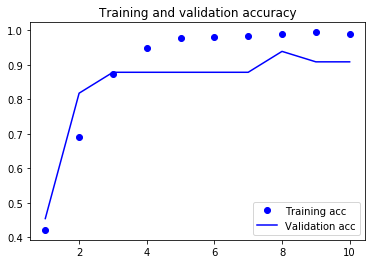

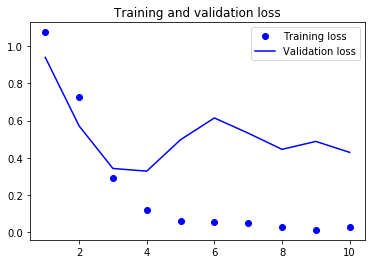

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(1, 28, 28, 3)


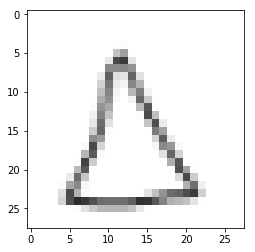

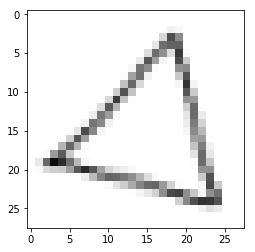

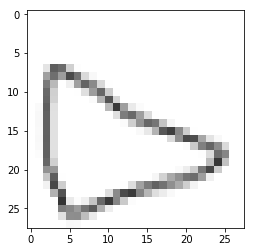

<Figure size 432x288 with 0 Axes>

In [10]:
imgs_path = ['test_set/triangles/drawing(90).png','test_set/triangles/drawing(92).png','test_set/triangles/drawing(93).png']
for img_path in imgs_path:
    img = image.load_img(img_path, target_size=(28, 28))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.imshow(img_tensor[0])
    plt.figure()
print(img_tensor.shape)

In [40]:
layer_outputs = [layer.output for layer in model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [41]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation


In [42]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


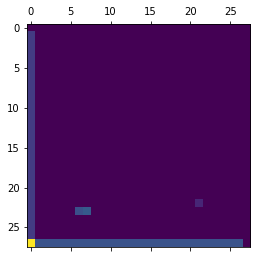

In [43]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')


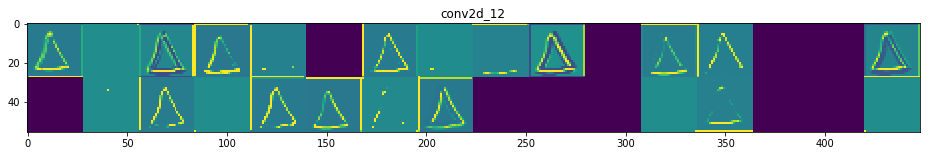

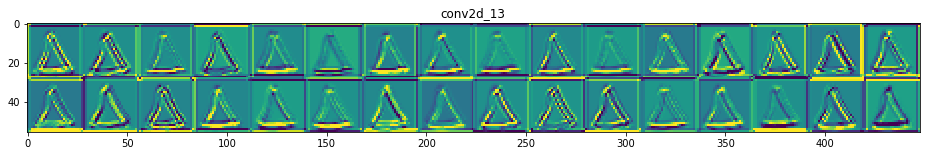

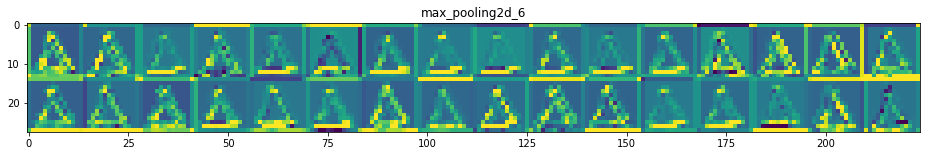

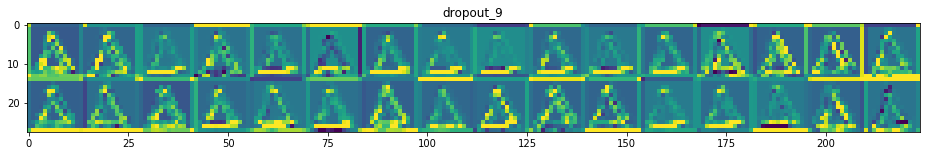

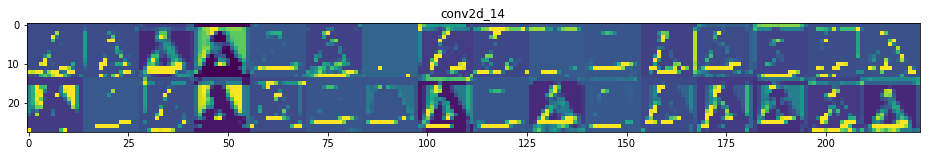

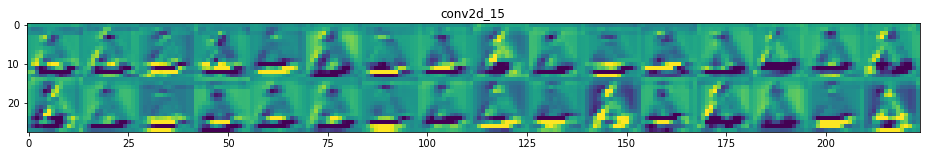

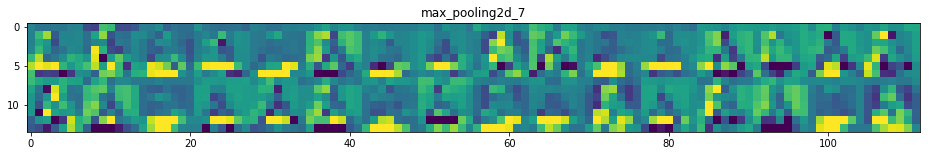

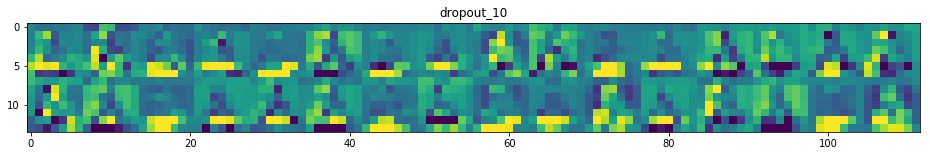

In [45]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')